In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

# Step 1 - File parsing for Krona-tools

#Command line code to produce counts

- less -S SRR492183.kraken

- cut -f2 week13_data/KRAKEN/SRR492183.kraken | sort | uniq -c > t_SRR492183.kraken
- cut -f2 week13_data/KRAKEN/SRR492186.kraken | sort | uniq -c > t_SRR492186.kraken
- cut -f2 week13_data/KRAKEN/SRR492188.kraken | sort | uniq -c > t_SRR492188.kraken
- cut -f2 week13_data/KRAKEN/SRR492189.kraken | sort | uniq -c > t_SRR492189.kraken
- cut -f2 week13_data/KRAKEN/SRR492190.kraken | sort | uniq -c > t_SRR492190.kraken
- cut -f2 week13_data/KRAKEN/SRR492193.kraken | sort | uniq -c > t_SRR492193.kraken
- cut -f2 week13_data/KRAKEN/SRR492194.kraken | sort | uniq -c > t_SRR492194.kraken
- cut -f2 week13_data/KRAKEN/SRR492197.kraken | sort | uniq -c > t_SRR492197.kraken

In [2]:
#re-writting files to be tab seperated. I couldn't figure out how to replace ; with a tab using the command line :(
#If I could have, may have saved the space of making these extra files

file_ext = ['83', '86', '88', '89', '90','93', '94', '97']
for i in range(0,len(file_ext)):
    
    fs = open('t_SRR4921' + file_ext[i] + '.kraken', 'r')
    new_fs = open('Day' + str(i) +'.kraken', 'w')
    
    for line in fs:
        tab_split = line.replace(';','\t')
        new_fs.write(tab_split + '\n')
    
    fs.close()
    new_fs.close()
    

#Running ktImportText and command line code

- for day in { 0 1 2 3 4 5 6 7 }
- do
    ktImportText -o Day${day}.krona.html Day${day}.kraken
- done

# Question 1 answer:
- There is a dramatic increase from day 0 to day 1 in the amount of enterococcus faecalis. Gradually over the course of the week this species decreases in the total microbiome. At the same time, as the week progresses there is greater diversity of species with an increase in cutibacterium and staphylococcus. 


# Step 2 - Binning! 

# Question 2 answer:

- It seems like the best metrics for grouping together the contigs would be the use of k-mers and the matching between these k-mers to generate bins of interest. 

#COMMAND LINE CODE FOR ALIGNMENT 

- bwa index assembly.fasta

- for reads in SRR492183 SRR492186 SRR492188 SRR492189 SRR492190 SRR492193 SRR492194 SRR492197
- do
    bwa mem week13_data/assembly.fasta week13_data/READS/${reads}_1.fastq week13_data/READS/${reads}_2.fastq ${reads}.sam
    samtools view -bSo ${reads}.bam ${reads}.SAM
    samtools sort ${reads}.bam -o ${reads}.sorted.bam    
done

#COMMAND LINE CODE FOR BINNING

- jgi_summarize_bam_contig_depths --outputDepth depth.txt *.sorted.bam

- metabat2 -i week13_data/assembly.fasta -a depth.txt -o week13_data/mybins
 

# Question 3 answers:
- a. There are 6 resulting bins. 
- b. Super roughly, the characters of the total assembly is 38856945 (wc -m assmebly.fasta). Each of the bins are smaller, and adding all their characters together: 2752195 + 2292366 + 1683938 + 1249747 + 2525551 + 2910800 = 13414597. (13414597/38856945)* 100 = 34.5%. These bins represent roughly 1/3 of the assembly. (Again recognizing this is a super rough estimate as it doesn't acount for the non-sequence characters)
- c. Most of the bins are between 1-3 million characters, so these files seem to be the right size for a prokaryote genome given they tend to be between 0.5-12 million bases in size. 
- d. Compare the bins to the reference genome of the species they most strongly represent. Compare the amount of proper alighnment for amount of completeness, and mismatched regions to the reference

# Step 3 - Estimating taxonomy

In [3]:
#parse the bins for Nodes, pull the corresponding line from assembly and count
fs_krack = open('week13_data/KRAKEN/assembly.kraken','r')
krack_assembly = fs_krack.readlines()
fs_krack.close()

fs_bin = open('bins/bin.1.fa', 'r')
bin_lines = fs_bin.readlines()

fs_bin.close()

bin_dictionary = {}

for i in bin_lines:
    if '>' in i:
        node = str(i.strip()[1:])
        for line in krack_assembly:
            if node in line:
                bacteria_key = line.split('\t')[1]
                bin_dictionary.setdefault(bacteria_key, 0)
                bin_dictionary[bacteria_key] += 1
                
print(bin_dictionary)

{'root;cellular organisms;Bacteria;Terrabacteria group;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus haemolyticus;Staphylococcus haemolyticus JCSC1435\n': 46, 'root;cellular organisms;Bacteria;Terrabacteria group;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus epidermidis;Staphylococcus epidermidis RP62A\n': 3, 'root;cellular organisms;Bacteria;Terrabacteria group;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus epidermidis;Staphylococcus epidermidis ATCC 12228\n': 4, 'root;cellular organisms;Bacteria;Terrabacteria group;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus aureus;Staphylococcus aureus subsp. aureus;Staphylococcus aureus subsp. aureus ST72;Staphylococcus aureus subsp. aureus CN1\n': 1, 'root;cellular organisms;Bacteria;Terrabacteria group;Firmicutes;Bacilli;Bacillales;Staphylococcaceae;Staphylococcus;Staphylococcus epidermidis\n': 2, 'root;cellular organis

In [4]:
#inspired to make a function because it's been months since the last one
def bin_counter(bin_num, bin_input):
    fs_krack = open('week13_data/KRAKEN/assembly.kraken','r')
    krack_assembly = fs_krack.readlines()
    fs_krack.close()

    fs_bin = open('bins/bin.' + bin_input + '.fa', 'r')
    bin_lines = fs_bin.readlines()

    fs_bin.close()

    bin_dictionary = {}

    for i in bin_lines:
        if '>' in i:
            node = str(i.strip()[1:])
            for line in krack_assembly:
                if node in line:
                    bacteria_key = line.split('\t')[1]
                    bin_dictionary.setdefault(bacteria_key, 0)
                    bin_dictionary[bacteria_key] += 1
    
    fs_written = open('bin'+ str(bin_num) + 'counted.txt', 'w')
    for key, val in bin_dictionary.items():
        fs_written.write(key + ': ')
        fs_written.write(str(val) + '\n')
    
    max_value = max(bin_dictionary, key = lambda k: bin_dictionary[k])
    fs_written.write('Most common species \t' + max_value )
    fs_written.close()

In [5]:
all_da_bins = ['1','2','3','4','5','6','7','8']
for collection in all_da_bins:
    bin_counter(collection, collection)

# Question 4 answers:
1. Each bin represents the following genomes: 
- Bin 1- Staphylococcus haemolyticus
- Bin 2- Leuconostoc citreum
- Bin 3- Staphylococcus lugdunensis
- Bin 4- Enterococcus faecalis
- Bin 5- Cutibacterium avidum
- Bin 6- Staphylococcus epidermidis
- Bin 7- Staphylococcus aureus
- Bin 8- Anaerococcus prevotii is the most strongly represented, but barely. Maybe this bin is like a 'misc' file. 

2. Parse your bins for species specific genes such as ribosomal genes. These genes are unqiue to different species and can be used for taxonomic definitions and relateness.  

# Step 4 Abundance Heatmap

In [6]:
abundance = pd.read_csv("abundance_table.tab", delimiter = '\t')
abundance


,Genomic bins,SRR492186,SRR492066,SRR492182,SRR492188,SRR492196,SRR492183,SRR492184,SRR492185,SRR492065,SRR492187,SRR492197,SRR492189,SRR492195,SRR492194,SRR492193,SRR492192,SRR492191,SRR492190
0,bin.1,167.273691,67.688884,54.858154,102.432386,335.756912,50.103235,96.383771,175.127948,71.420624,190.391037,72.544371,97.521190,49.834345,53.357374,172.449773,179.006341,14.685431,14.523105
1,bin.4,9348.741359,7247.577187,4178.397657,8139.870719,11597.033828,4115.242526,11633.667679,9219.720953,7240.045338,9979.380909,8745.103316,8308.156703,6646.119922,6550.505763,6267.155205,6151.257743,5780.879180,5267.858711
2,bin.2,8.887730,5.406628,1.986297,5.838109,8.348499,1.751119,31.799458,9.170054,6.087799,37.581807,19.275630,5.929623,3.451473,3.259988,1.804228,1.629252,4.652603,4.583909
3,bin.5,0.552469,2034.534641,1232.387641,0.875860,0.436084,1566.783656,670.257316,0.747395,1869.640953,108.026882,4250.653466,0.356678,593.767516,457.543378,315.740755,282.011644,0.772755,1.251430
4,bin.6,820.872805,392.881731,1427.905710,1033.761424,1884.339618,1335.147536,1027.807284,850.342196,427.134461,2391.501197,936.681889,999.273162,1143.743857,1187.660153,1670.022745,1719.723610,1136.902519,1071.641137
5,bin.7,1.452063,681.886830,2.467008,1.347894,3.084744,1.287979,2124.191118,2.312693,714.809488,7.140755,590.194971,0.747525,1093.414384,1124.427189,6.459688,7.175036,1.496781,3.287205
6,bin.8,0.065351,3219.448810,0.223916,4.223711,0.698382,0.186461,889.316796,0.181546,3498.783627,1.199693,3366.910935,0.979570,71.465536,73.851083,1.211367,4.114233,0.088835,0.259990
7,bin.3,6.194380,23.178964,2.759951,0.475050,1.563200,2.555610,1.259343,6.237916,24.206000,137.042032,10.595311,0.333899,6.668268,6.639770,78.291586,79.491024,0.523699,0.491073


In [7]:
bin_labels = ['Staphylococcus haemolyticus', 'Enterococcus faecalis', 'Leuconostoc citreum', 'Cutibacterium avidum', 'Staphylococcus epidermidis', 'Staphylococcus aureus', 'Misc', 'Staphylococcus lugdunensis']
abundance['Genomic bins'] = bin_labels
abundance

,Genomic bins,SRR492186,SRR492066,SRR492182,SRR492188,SRR492196,SRR492183,SRR492184,SRR492185,SRR492065,SRR492187,SRR492197,SRR492189,SRR492195,SRR492194,SRR492193,SRR492192,SRR492191,SRR492190
0,Staphylococcus haemolyticus,167.273691,67.688884,54.858154,102.432386,335.756912,50.103235,96.383771,175.127948,71.420624,190.391037,72.544371,97.521190,49.834345,53.357374,172.449773,179.006341,14.685431,14.523105
1,Enterococcus faecalis,9348.741359,7247.577187,4178.397657,8139.870719,11597.033828,4115.242526,11633.667679,9219.720953,7240.045338,9979.380909,8745.103316,8308.156703,6646.119922,6550.505763,6267.155205,6151.257743,5780.879180,5267.858711
2,Leuconostoc citreum,8.887730,5.406628,1.986297,5.838109,8.348499,1.751119,31.799458,9.170054,6.087799,37.581807,19.275630,5.929623,3.451473,3.259988,1.804228,1.629252,4.652603,4.583909
3,Cutibacterium avidum,0.552469,2034.534641,1232.387641,0.875860,0.436084,1566.783656,670.257316,0.747395,1869.640953,108.026882,4250.653466,0.356678,593.767516,457.543378,315.740755,282.011644,0.772755,1.251430
4,Staphylococcus epidermidis,820.872805,392.881731,1427.905710,1033.761424,1884.339618,1335.147536,1027.807284,850.342196,427.134461,2391.501197,936.681889,999.273162,1143.743857,1187.660153,1670.022745,1719.723610,1136.902519,1071.641137
5,Staphylococcus aureus,1.452063,681.886830,2.467008,1.347894,3.084744,1.287979,2124.191118,2.312693,714.809488,7.140755,590.194971,0.747525,1093.414384,1124.427189,6.459688,7.175036,1.496781,3.287205
6,Misc,0.065351,3219.448810,0.223916,4.223711,0.698382,0.186461,889.316796,0.181546,3498.783627,1.199693,3366.910935,0.979570,71.465536,73.851083,1.211367,4.114233,0.088835,0.259990
7,Staphylococcus lugdunensis,6.194380,23.178964,2.759951,0.475050,1.563200,2.555610,1.259343,6.237916,24.206000,137.042032,10.595311,0.333899,6.668268,6.639770,78.291586,79.491024,0.523699,0.491073


In [8]:
abundance_week = abundance.iloc[:, [0, 6, 1, 4, 12, 18, 15,14, 11]]
abundance_week = abundance_week.set_index("Genomic bins")

In [9]:
abundance_week

,SRR492183,SRR492186,SRR492188,SRR492189,SRR492190,SRR492193,SRR492194,SRR492197
Genomic bins,,,,,,,,
Staphylococcus haemolyticus,50.103235,167.273691,102.432386,97.521190,14.523105,172.449773,53.357374,72.544371
Enterococcus faecalis,4115.242526,9348.741359,8139.870719,8308.156703,5267.858711,6267.155205,6550.505763,8745.103316
Leuconostoc citreum,1.751119,8.887730,5.838109,5.929623,4.583909,1.804228,3.259988,19.275630
Cutibacterium avidum,1566.783656,0.552469,0.875860,0.356678,1.251430,315.740755,457.543378,4250.653466
Staphylococcus epidermidis,1335.147536,820.872805,1033.761424,999.273162,1071.641137,1670.022745,1187.660153,936.681889
Staphylococcus aureus,1.287979,1.452063,1.347894,0.747525,3.287205,6.459688,1124.427189,590.194971
Misc,0.186461,0.065351,4.223711,0.979570,0.259990,1.211367,73.851083,3366.910935
Staphylococcus lugdunensis,2.555610,6.194380,0.475050,0.333899,0.491073,78.291586,6.639770,10.595311


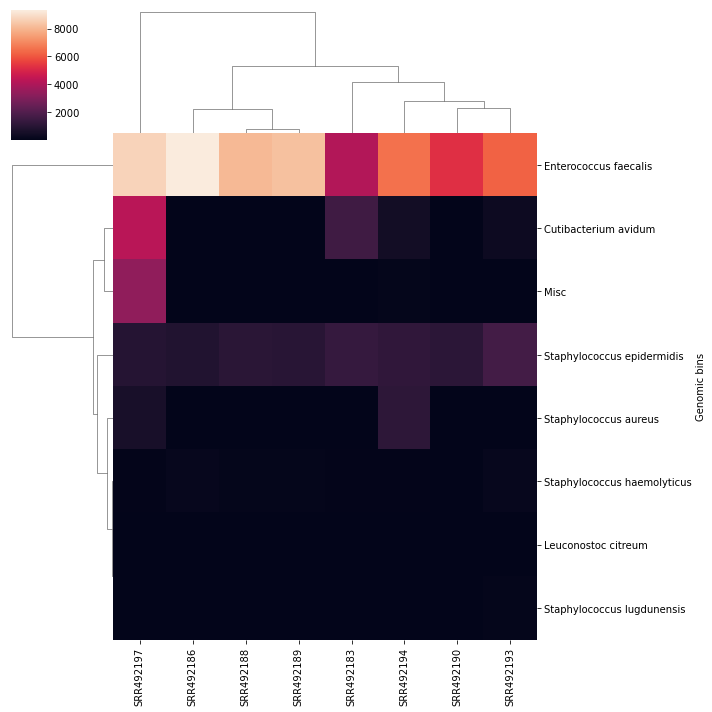

In [10]:
sb.clustermap(abundance_week)

# Question 5 answer:
- This heatmap is very similar to what I saw in krona maps data set - there is dramatic changes in Entercoccus over the different samples and it is also the most highly expressed bacteria in this data set. Eventually Cutibacterium begins to be more highly expressed towards the end of the week. 